In [15]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pydicom
import gdcm
import os
import cv2
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection


In [3]:
INPUT_FOLDER = '../Datasets/DICOM Native anonymized/'
over_patients = os.listdir(INPUT_FOLDER)

In [18]:
def get_patient_target_folder(patient_parent_folder):
    patient_target_folder = os.listdir(patient_parent_folder)[0]
    patient_target_folder = patient_parent_folder + '/' + patient_target_folder
    return patient_target_folder

def get_list_patients_paths(input_folder):
    list_patients_paths = []
    for element in os.listdir(input_folder):
        patient_parent_folder = os.path.join(INPUT_FOLDER, element)
        patient_target_folder = get_patient_target_folder(patient_parent_folder)
        list_patients_paths.append(patient_target_folder)
        # print(patient_target_folder)
    return list_patients_paths

list_patients_paths = get_list_patients_paths(INPUT_FOLDER)
print(list_patients_paths[:3])


['../Datasets/DICOM Native anonymized/1.2.124.113532.12.10699.12127.20150930.134304.394576165/1.2.392.200036.9116.2.6.1.3268.2047269746.1444918787.14638', '../Datasets/DICOM Native anonymized/1.2.124.113532.12.10699.12127.20140805.115557.375988118/1.3.12.2.1107.5.1.4.53642.30000014101706044771800011216', '../Datasets/DICOM Native anonymized/1.3.12.2.1107.5.1.4.53642.30000011020807151056200000013/1.3.12.2.1107.5.1.4.53642.30000011020806384268700000583']


In [7]:
# source: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
# Load the scans in given folder path
def load_scan(path):
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [8]:
# source: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [9]:
# sample_patient = list_patients_paths[1]
# sample_patient = '../DaneDICOM/DICOMNativeAnonymized/1.2.124.113532.12.10699.12127.20110321.143718.22145985/1.3.12.2.1107.5.1.4.53642.30000011032114095153100000518'
# sample_patient = 'C:/Users/User/Documents/DaneDICOM/DICOMNativeAnonymized/1.2.124.113532.12.10699.12127.20110321.143718.22145985/1.3.12.2.1107.5.1.4.53642.30000011032114095153100000518'
# first_patient = load_scan(sample_patient)
# first_patient_pixels = get_pixels_hu(first_patient)
# plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
# plt.xlabel("Hounsfield Units (HU)")
# plt.ylabel("Frequency")
# plt.show()

# # Show some slice in the middle
# plt.imshow(first_patient_pixels[0], cmap=plt.cm.gray)
# plt.show()

In [10]:
#print(len(list_patients_paths))
for patient_path in list_patients_paths:
    slices = []
    slices = [pydicom.dcmread(patient_path + '/' + s,force=True) for s in os.listdir(patient_path) if s.endswith('dcm')]
#     slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        print(len(slices), slices[0].pixel_array.shape)
    except:
        print("Pixel array not found")
#     plt.imshow(slices[0].pixel_array)
    #plt.show()

100 (512, 512)
295 (512, 512)
96 (512, 512)
23 (512, 512)
87 (512, 512)
40 (512, 512)
181 (512, 512)
47 (512, 512)
56 (512, 512)
59 (512, 512)
54 (512, 512)
98 (512, 512)
54 (512, 512)
56 (512, 512)
62 (512, 512)
53 (512, 512)
133 (512, 512)
58 (512, 512)
82 (512, 512)
50 (512, 512)
47 (512, 512)
50 (512, 512)
64 (512, 512)
126 (512, 512)
70 (512, 512)
88 (512, 512)
52 (512, 512)
84 (512, 512)
49 (512, 512)
50 (512, 512)
132 (512, 512)
56 (512, 512)
88 (512, 512)
69 (512, 512)
87 (512, 512)
84 (512, 512)
82 (512, 512)
95 (512, 512)
53 (512, 512)
94 (512, 512)
48 (512, 512)
34 (512, 512)
89 (512, 512)
80 (512, 512)
59 (512, 512)
57 (512, 512)
46 (512, 512)
49 (512, 512)
68 (512, 512)
51 (512, 512)
90 (512, 512)
93 (512, 512)
47 (512, 512)
95 (512, 512)
174 (512, 512)
81 (512, 512)
128 (512, 512)
98 (512, 512)
89 (512, 512)
62 (512, 512)
70 (512, 512)
92 (512, 512)
45 (512, 512)
65 (512, 512)
47 (512, 512)
73 (512, 512)
96 (512, 512)
49 (512, 512)
58 (512, 512)
72 (512, 512)
84 (512, 512

(100, 512, 512)


NameError: name 'cv2' is not defined

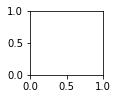

In [13]:
for patient_path in list_patients_paths[:1]:
    
    patient_path = patient_path + '/'

    dicomFiles = [file for file in os.listdir(patient_path) if file.endswith('dcm')]
    dicoms = []
    for file in dicomFiles:
        ds = pydicom.dcmread(patient_path + file, force=True)
        dicoms.append((patient_path+file,int(ds[0x0020,0x0013].value)))    #tu dzieje się magia odpowiedzialna za porządkowanie, tag DICOMowy [0x0020,0x0013]  zawiera informację o pozycji elementu w serii np. https://www.dicomlibrary.com/dicom/dicom-tags/
    dicoms = sorted(dicoms, key=lambda x: x[1])

    ps = ds.PixelSpacing
    ss = ds.SliceThickness
    
    im3D = []
    for d in dicoms:
        ds = pydicom.dcmread(d[0], force=True)
        im3D.append(ds.pixel_array)                           #składam obrazki w 3D

    im3D = np.asarray(im3D)                                    #konwersja listy do macierzy 3D
    print(im3D.shape)                                              # (90,512,512)         trzeci wymiar jest pierwszy... Jeśli to przeszkadza, to np.swapaxes() pomaga        fig = plt.figure()
    fig = plt.figure()
    for s in range(0,im3D.shape[0]):                           #wyświetlam
        y = fig.add_subplot(3, 4, s+1)
        smaller_image = cv2.resize(np.array(im3D[s]), (150,150))
        plt.imshow(smaller_image, cmap = 'bone')
        plt.show()

In [12]:
im3D.shape
# pixel aspects, assuming all slices are the same
# ps = im3D[0].PixelSpacing
# ss = im3D[0].SliceThickness
ax_aspect = ps[1]/ps[0]
sag_aspect = ps[1]/ss
cor_aspect = ss/ps[0]

NameError: name 'im3D' is not defined

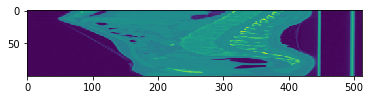

In [35]:
# plot 3 orthogonal slices
# a1 = plt.subplot(3, 1, 1)
plt.imshow(im3D[:, :, im3D.shape[2]//2])
# plt.set_aspect(ax_aspect)
plt.show()


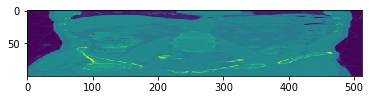

In [36]:
# a2 = plt.subplot(3, 1, 2)
plt.imshow(im3D[:, im3D.shape[1]//2, :])
# a2.set_aspect(sag_aspect)

plt.show()



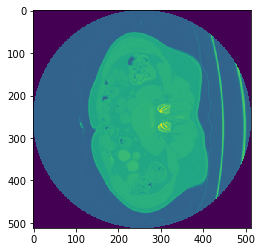

In [37]:
# a3 = plt.subplot(3, 1, 3)
plt.imshow(im3D[im3D.shape[0]//2, :, :].T)
# a3.set_aspect(cor_aspect)

plt.show()

In [ ]:
# source: https://www.kaggle.com/gzuidhof/data-science-bowl-2017/full-preprocessing-tutorial
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.nd
    image.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing

In [ ]:
# pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
# print("Shape before resampling\t", first_patient_pixels.shape)
# print("Shape after resampling\t", pix_resampled.shape)

In [16]:
def plot_3d(image, threshold=-300):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    p = p[:,:,::-1]
    
    verts, faces = measure.marching_cubes_classic(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

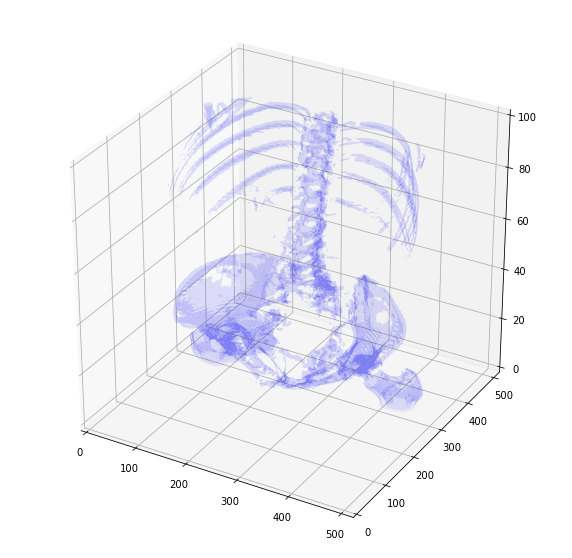

In [17]:
plot_3d(im3D, 400)